In [116]:
import numpy as np
import xarray as xr 
import matplotlib.pyplot as plt 
from UQ_utils import preprocess, make_colorbar
from thermal.plotting import enthalpy_pcolormesh
from thermal.derived_fields import calc_mean_enthalpy


plt.rcParams['text.usetex'] = True

In [2]:
ssd_fp = '/Volumes/thermal_ssd/new_1aTST/'

In [22]:
ref = 0.006
ds  = xr.open_mfdataset(ssd_fp+'*_f_dd*.zarr', engine='zarr', data_vars='minimal', preprocess=preprocess)

# make volume realtive 
ds['relative_volume'] = ds.relative_volume / ds.relative_volume.isel(t=0)

In [4]:
Z = ds.isel(t=-500, coord_2=-1).Z
M = ds.isel(t=slice(-500,-490),coord_2=-1).surf_melt
R = ds.isel(t=slice(-500,-490),coord_2=-1).runoff_frac


(2250.0, 2750.0)

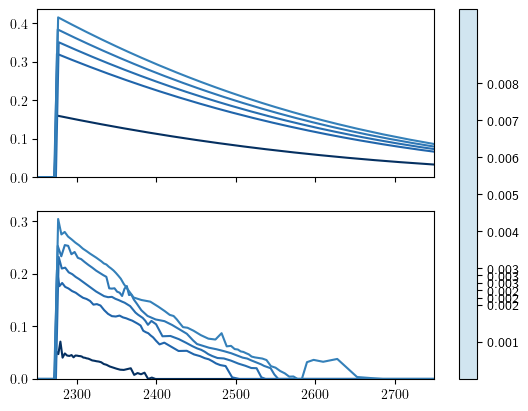

In [40]:
fig, ax = plt.subplots(2,1, sharex=True)

# make the discrete colorbar, which should capture each individual parameter tested
cmap, norm, s_map, bounds = make_colorbar(ds.f_dd, ref)

for f_dd in ds.f_dd[:5]: 
    
    color = cmap(norm(float(f_dd)))
                 
    ax[0].plot(Z.sel(f_dd=f_dd), M.sel(f_dd=f_dd).sum('t'), color=color)
    
    ax[1].plot(Z.sel(f_dd=f_dd), (M*R).sel(f_dd=f_dd).sum('t'), color=color)
    

cbar = fig.colorbar(s_map,
                    ax=ax, 
                    spacing='proportional',
                    ticks=s_map.get_array(),
                    boundaries=bounds,
                    drawedges=True,
                    format="{x:.3f}"
                   )

ax[0].set_ylim(0, None)
ax[1].set_ylim(0, None)
ax[1].set_xlim(2250, 2750)

In [20]:
bounds

array([0.  , 0.01])

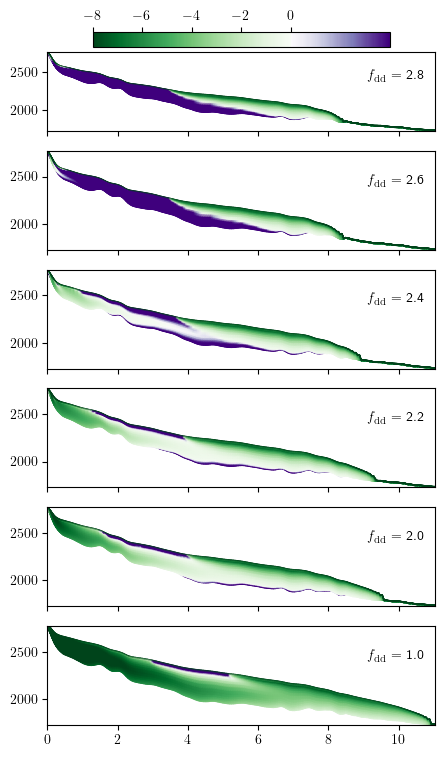

In [400]:
fig, ax = plt.subplots(6,1, sharex=True, sharey=True, 
                       figsize=(5,9))

for i, f_dd in enumerate(ds.f_dd[:6][::-1]):

    im = enthalpy_pcolormesh(ds.sel(f_dd=f_dd), -500, axes=ax[i])
    
    label = r'$f_{\rm dd}$ = ' + f'{float(f_dd)*1e3:.1f}'
    
    ax[i].text(0.9, 0.7, label,
               ha='center', va='center', transform=ax[i].transAxes)
    
fig.colorbar(im, ax=ax[0], location='top')

In [39]:
print(float((ds.isel(f_dd=1) - ds.isel(f_dd=0)).relative_volume.isel(t=-500)))

print(float((calc_mean_enthalpy((ds.isel(f_dd=1))) - calc_mean_enthalpy(ds.isel(f_dd=0))).isel(t=-500)) / 1e3)

-0.49140761483779594
4.823831062814977


In [389]:
def compute_basal_temp_layer_thickness(src): 
    mask = xr.where(src.enthalpy_h >= src['phase change enthalpy'], True, False)
    
    # get the height of gricells which are temperate
    height = (src.height.isel(coord_2=-1) - src.depth).where(mask)
    
    def find_thickness(column): 
        copy = column
        idxes = copy.isnull().astype(int).assign_coords(idx = ('coord_2', np.arange(0,16))).diff('coord_2').where(lambda x: x==1, drop=True)

        if idxes.size == 0: 
            thickness = xr.DataArray(0, coords=column.coords).squeeze()
        else: 
            idx = idxes.idx[0] 
            thickness = column.isel(coord_2=idx-1).squeeze().drop_vars('idx')    
    
        # if thickness.values == height.isel(coord_2=-1).values: 
        #     thickness = thickness *np.nan
        return thickness
    
    thickness = height.groupby('coord_1').apply(find_thickness)
    
    
    return xr.where(np.abs(thickness - src.height.isel(coord_2=-1)) <= 20, np.nan, thickness)

In [395]:
src = ds.sel(f_dd=0.0024).isel(t=-500).compute()

In [396]:
mask = xr.where(src.enthalpy_h >= src['phase change enthalpy'], True, False)
height = (src.height.isel(coord_2=-1) - src.depth).where(mask)

(0.0, 184.58632155118556)

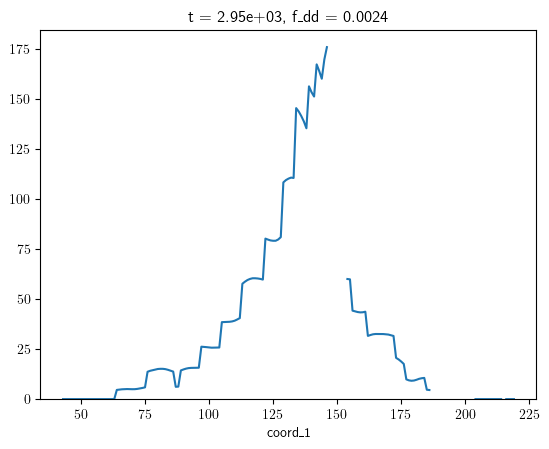

In [397]:
compute_basal_temp_layer_thickness(src).plot()
plt.ylim(0,None)

In [401]:
src = ds.sel(f_dd=0.001).isel(t=-500).compute()

(<Figure size 600x300 with 2 Axes>,
 <AxesSubplot: >,
 <matplotlib.colorbar.Colorbar at 0x1495d2370>)

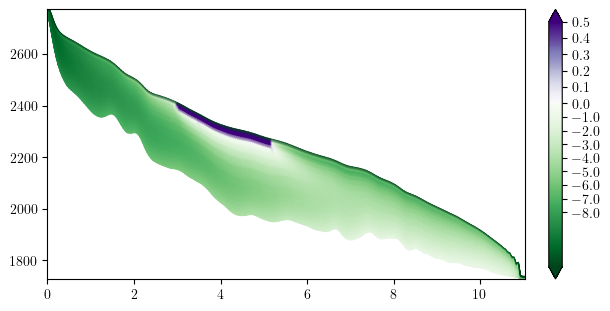

In [405]:
enthalpy_pcolormesh(src, 0, T_min=-12)

In [413]:
src.temperature.isel(coord_2=slice(0,14)).min()

<xarray.DataArray 'temperature' ()>
array(-16.63890441)
Coordinates:
    t        float64 2.95e+03
    f_dd     float64 0.001